In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models

from torch.utils.data import Dataset, DataLoader
from PIL import Image
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report


In [3]:
class EmotionDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = Path(root_dir)
        self.transform = transform

        # folder classes
        self.classes = sorted([d.name for d in self.root_dir.iterdir() if d.is_dir()])
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}

        self.samples = []
        for cls in self.classes:
            cls_dir = self.root_dir / cls
            for img_path in cls_dir.iterdir():
                if img_path.suffix.lower() in [".jpg", ".jpeg", ".png"]:
                    self.samples.append((str(img_path), self.class_to_idx[cls]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, label


In [5]:
def create_model(num_classes, pretrained=True):
    model = models.resnet50(weights="IMAGENET1K_V2" if pretrained else None)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model


In [6]:
DATA_ROOT = "dataset"  # CHANGE IF NEEDED

train_tf = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.2, 0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_tf = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

train_dataset = EmotionDataset(f"{DATA_ROOT}/train", transform=train_tf)
valid_dataset = EmotionDataset(f"{DATA_ROOT}/val", transform=val_tf)
test_dataset  = EmotionDataset(f"{DATA_ROOT}/test", transform=val_tf)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

print("Train samples:", len(train_dataset))
print("Val samples:", len(valid_dataset))
print("Test samples:", len(test_dataset))


Train samples: 2740
Val samples: 683
Test samples: 266


In [7]:
def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    preds = []
    labels = []

    with torch.no_grad():
        for images, y in loader:
            images, y = images.to(device), y.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            preds.extend(predicted.cpu().numpy())
            labels.extend(y.cpu().numpy())

            total += y.size(0)
            correct += (predicted == y).sum().item()

    acc = correct / total
    return acc, np.array(preds), np.array(labels)


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 3  # change if needed

model = create_model(num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

ckpt_dir = Path("checkpoints")
ckpt_dir.mkdir(exist_ok=True)


In [9]:
EPOCHS = 12
best_val_acc = 0

for epoch in range(1, EPOCHS + 1):
    model.train()
    running_loss = 0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total

    val_acc, _, val_labels = evaluate(model, valid_loader)
    val_loss = 0  # optional if you compute val_loss

    scheduler.step()

    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_acc"].append(val_acc)
    history["val_loss"].append(val_loss)

    print(f"Epoch {epoch}/{EPOCHS} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

    # save best
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), ckpt_dir / "best.pth")
        print("Saved BEST model")

    torch.save(model.state_dict(), ckpt_dir / "last.pth")

torch.save(history, "training_history.pth")
print("Training complete. Best Val Acc:", best_val_acc)


Epoch 1/12 | Train Acc: 0.7325 | Val Acc: 0.8682
Saved BEST model
Epoch 2/12 | Train Acc: 0.9161 | Val Acc: 0.9136
Saved BEST model
Epoch 3/12 | Train Acc: 0.9785 | Val Acc: 0.9268
Saved BEST model
Epoch 4/12 | Train Acc: 0.9905 | Val Acc: 0.9370
Saved BEST model
Epoch 5/12 | Train Acc: 0.9912 | Val Acc: 0.9283
Epoch 6/12 | Train Acc: 0.9964 | Val Acc: 0.9385
Saved BEST model
Epoch 7/12 | Train Acc: 0.9971 | Val Acc: 0.9414
Saved BEST model
Epoch 8/12 | Train Acc: 0.9978 | Val Acc: 0.9429
Saved BEST model
Epoch 9/12 | Train Acc: 0.9989 | Val Acc: 0.9429
Epoch 10/12 | Train Acc: 0.9989 | Val Acc: 0.9400
Epoch 11/12 | Train Acc: 0.9996 | Val Acc: 0.9400
Epoch 12/12 | Train Acc: 0.9993 | Val Acc: 0.9370
Training complete. Best Val Acc: 0.9428989751098097


In [10]:
model.load_state_dict(torch.load(ckpt_dir / "best.pth", map_location=device))

test_acc, preds, labels = evaluate(model, test_loader)
print("Test Accuracy:", test_acc)


Test Accuracy: 0.8947368421052632


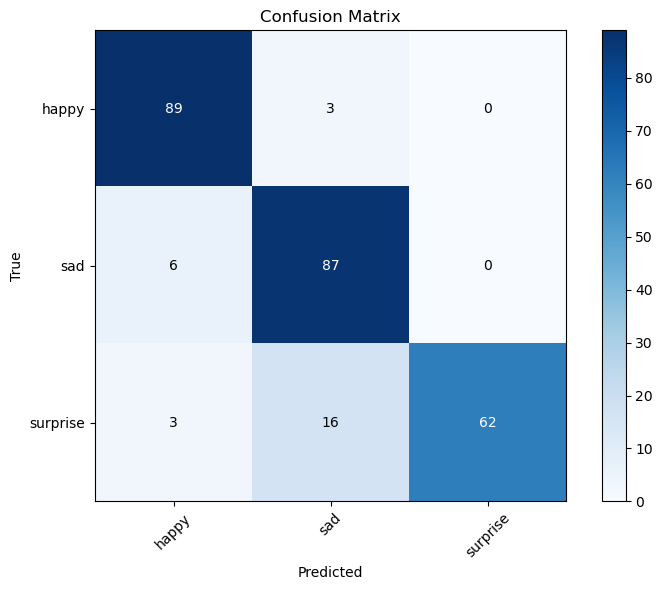

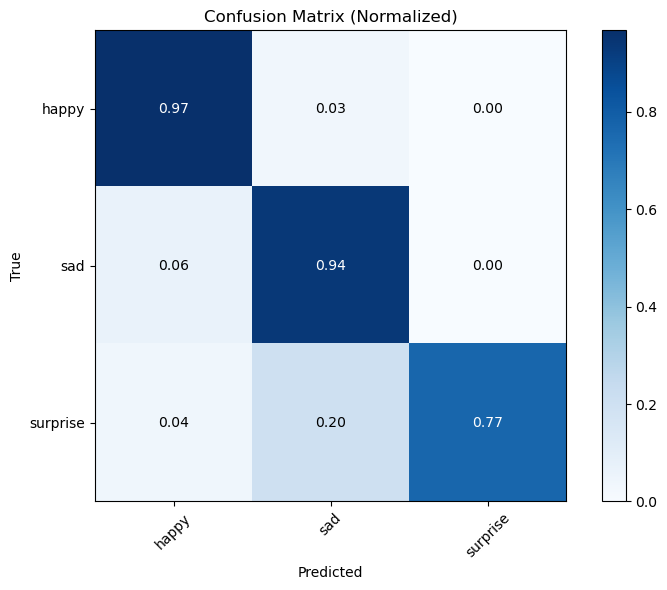


Classification Report:
              precision    recall  f1-score   support

       happy     0.9082    0.9674    0.9368        92
         sad     0.8208    0.9355    0.8744        93
    surprise     1.0000    0.7654    0.8671        81

    accuracy                         0.8947       266
   macro avg     0.9096    0.8894    0.8928       266
weighted avg     0.9056    0.8947    0.8938       266



In [11]:
CLASS_LABELS = train_dataset.classes  # ["happy", "sad", "surprise"]

def plot_confusion(cm, class_labels, normalize=False):
    if normalize:
        cm = cm.astype(float) / cm.sum(axis=1, keepdims=True)

    plt.figure(figsize=(8,6))
    plt.imshow(cm, cmap="Blues")
    plt.title("Confusion Matrix" + (" (Normalized)" if normalize else ""))
    plt.colorbar()

    ticks = np.arange(len(class_labels))
    plt.xticks(ticks, class_labels, rotation=45)
    plt.yticks(ticks, class_labels)

    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2

    for i in range(len(cm)):
        for j in range(len(cm)):
            plt.text(j, i, format(cm[i, j], fmt),
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

cm = confusion_matrix(labels, preds)
plot_confusion(cm, CLASS_LABELS, normalize=False)
plot_confusion(cm, CLASS_LABELS, normalize=True)

print("\nClassification Report:")
print(classification_report(labels, preds, target_names=CLASS_LABELS, digits=4))


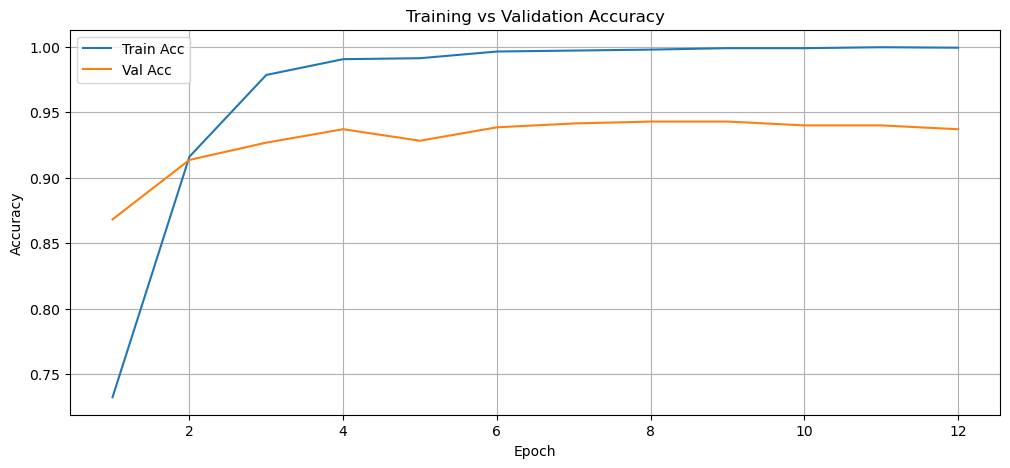

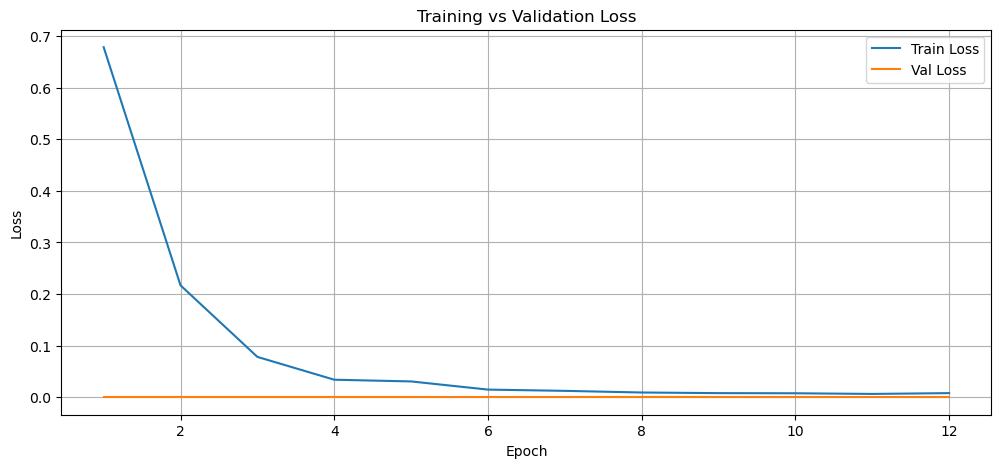

In [12]:
hist = torch.load("training_history.pth")

epochs = range(1, len(hist["train_acc"]) + 1)

plt.figure(figsize=(12,5))
plt.plot(epochs, hist["train_acc"], label="Train Acc")
plt.plot(epochs, hist["val_acc"], label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(12,5))
plt.plot(epochs, hist["train_loss"], label="Train Loss")
plt.plot(epochs, hist["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid()
plt.show()
